In [2]:
import sys
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pathlib import Path
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
src_path = str((Path.cwd().parent / 'src').resolve())
if src_path not in sys.path:
    sys.path.append(src_path)

from src.plot import plot_lstm_evaluation

In [4]:
# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
DATA_DIR = "../data/processed/"
MODEL_DIR = "../models/lstm/"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

train = pd.read_csv(DATA_DIR + "train.csv", usecols=["clean_text", "is_fake"])
val   = pd.read_csv(DATA_DIR + "val.csv", usecols=["clean_text", "is_fake"])
test  = pd.read_csv(DATA_DIR + "test.csv", usecols=["clean_text", "is_fake"])

# Drop any rows with missing values just in case
train.dropna(inplace=True), val.dropna(inplace=True), test.dropna(inplace=True)

# Extract texts and labels
X_train_text = train['clean_text'].values
y_train      = train['is_fake'].values
X_val_text   = val['clean_text'].values
y_val        = val['is_fake'].values
X_test_text  = test['clean_text'].values
y_test       = test['is_fake'].values

print(f"Train size: {len(X_train_text)} samples")
print(f"Val   size: {len(X_val_text)} samples")
print(f"Test  size: {len(X_test_text)} samples")

Train size: 44170 samples
Val   size: 9466 samples
Test  size: 9468 samples


In [6]:
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train_text)


with open(MODEL_DIR + "tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

def texts_to_padded_sequences(texts, tokenizer, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen,
                           padding='post', truncating='post')
    return padded

# Convert splits
X_train_seq = texts_to_padded_sequences(X_train_text, tokenizer, MAX_SEQUENCE_LENGTH)
X_val_seq   = texts_to_padded_sequences(X_val_text, tokenizer, MAX_SEQUENCE_LENGTH)
X_test_seq  = texts_to_padded_sequences(X_test_text, tokenizer, MAX_SEQUENCE_LENGTH)

print(f"Example sequence shape: {X_train_seq.shape} (samples, maxlen)")

Example sequence shape: (44170, 200) (samples, maxlen)


In [7]:
EMBEDDING_DIM = 100    # dimension of embedding vectors

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM),
    SpatialDropout1D(rate=0.2),
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
PATIENCE = 2
EPOCHS = 10
BATCH_SIZE = 64

callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=PATIENCE,
                  restore_best_weights=True),
    ModelCheckpoint(MODEL_DIR + 'best_lstm.h5',
                    monitor='val_loss',
                    save_best_only=True)
]

history = model.fit(
    X_train_seq, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val),
    callbacks=callbacks,
    verbose=1
)

model.save(MODEL_DIR + "final_lstm.keras")

Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7051 - loss: 0.5784

691/691 ━━━━━━━━━━━━━━━━━━━━ 86s 122ms/step - accuracy: 0.7052 - loss: 0.5784 - val_accuracy: 0.8166 - val_loss: 0.4431
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8038 - loss: 0.4536

691/691 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.8038 - loss: 0.4535 - val_accuracy: 0.8929 - val_loss: 0.2962
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8903 - loss: 0.2989

691/691 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.8903 - loss: 0.2988 - val_accuracy: 0.9199 - val_loss: 0.2223
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9270 - loss: 0.2085

691/691 ━━━━━━━━━━━━━━━━━━━━ 98s 142ms/step - accuracy: 0.9270 - loss: 0.2085 - val_accuracy: 0.9285 - val_loss: 0.1933
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9467 - loss: 0.1526

691/691 ━━━━━━━━━━━━━━━━━━━━ 152s 220ms/step - accuracy: 0.9467 - loss: 0.1526 - val_accuracy: 0.9453 - val_loss: 0.1510
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9575 - loss: 0.1176

691/691 ━━━━━━━━━━━━━━━━━━━━ 147s 212ms/step - accuracy: 0.9575 - loss: 0.1176 - val_accuracy: 0.9479 - val_loss: 0.1401
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9654 - loss: 0.0972

691/691 ━━━━━━━━━━━━━━━━━━━━ 166s 240ms/step - accuracy: 0.9654 - loss: 0.0972 - val_accuracy: 0.9507 - val_loss: 0.1350
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 167s 242ms/step - accuracy: 0.9726 - loss: 0.0811 - val_accuracy: 0.9513 - val_loss: 0.1388
Epoch 9/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 173s 250ms/step - accuracy: 0.9773 - loss: 0.0649 - val_accuracy: 0.9519 - val_loss: 0.1431


296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
--- Test Results ---
              precision    recall  f1-score   support

        real       0.96      0.95      0.96      5219
        fake       0.94      0.95      0.95      4249

    accuracy                           0.95      9468
   macro avg       0.95      0.95      0.95      9468
weighted avg       0.95      0.95      0.95      9468

ROC-AUC: 0.9890



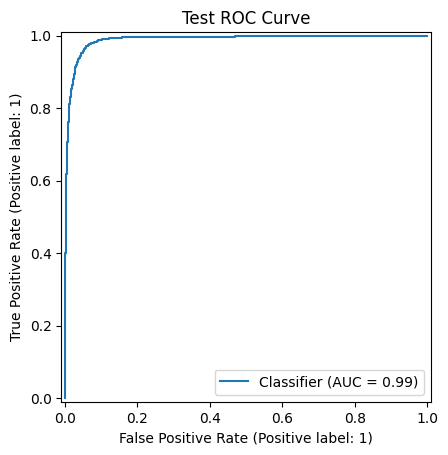

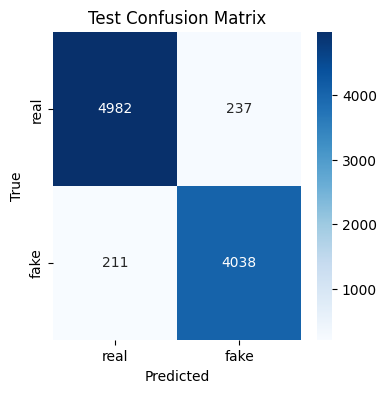

In [9]:
plot_lstm_evaluation("Test", model, X_test_seq, y_test)